# Image Captioning with MS-COCO Dataset

**Problem Statement:** Automatically describing the content of an image using natural language bridges Computer Vision and NLP. In this project, we use the MS-COCO dataset to train an encoder-decoder architecture for image captioning.

The following code is provided to help you get started. We recommend using GPUs train the models as image cpationing can be very intensive even using relatively simple models.

## 1. Install and Import Dependencies

In [2]:
# Install additional packages if needed
# !pip install pycocotools nltk

import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.transforms as T
from torchvision import models

import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import word_tokenize

In [3]:
# Checks which device to use (Datahub GPU is either RTX 2070 or RTX 2080)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.2.1+cu121
CUDA available: False
Using device: cpu


## 2. Download the MS-COCO Dataset

We download the 2017 training images and annotations. This is will create a data folder with MSCOCO inside. You only have to run this code once. **Note:** The full training set is ~18GB. So for this project, we will just use the validation set ~1GB. 

In [5]:
DATA_DIR = './data/coco'
os.makedirs(DATA_DIR, exist_ok=True)

# Download annotations (relatively small ~241MB)
ANNOTATIONS_URL = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

if not os.path.exists(os.path.join(DATA_DIR, 'annotations')):
    print("Downloading COCO annotations...")
    !wget -q {ANNOTATIONS_URL} -O {DATA_DIR}/annotations.zip
    !unzip -q {DATA_DIR}/annotations.zip -d {DATA_DIR}
    !rm {DATA_DIR}/annotations.zip
    print("Annotations downloaded!")
else:
    print("Annotations already exist.")

# Download validation images (smaller set, ~1GB - good for development)
VAL_IMAGES_URL = 'http://images.cocodataset.org/zips/val2017.zip'

if not os.path.exists(os.path.join(DATA_DIR, 'val2017')):
    print("Downloading COCO val2017 images...")
    !wget -q {VAL_IMAGES_URL} -O {DATA_DIR}/val2017.zip
    !unzip -q {DATA_DIR}/val2017.zip -d {DATA_DIR}
    !rm {DATA_DIR}/val2017.zip
    print("Validation images downloaded!")
else:
    print("Validation images already exist.")

print(f"\nDataset contents: {os.listdir(DATA_DIR)}")

Annotations already exist.
Validation images already exist.

Dataset contents: ['val2017', 'annotations']


## 3. Explore the Captions

In [6]:
# Load captions annotation file
# Using val set captions for development; switch to train for full training
captions_file = os.path.join(DATA_DIR, 'annotations', 'captions_val2017.json')

with open(captions_file, 'r') as f:
    captions_data = json.load(f)

print(f"Keys: {captions_data.keys()}")
print(f"Number of images: {len(captions_data['images'])}")
print(f"Number of captions: {len(captions_data['annotations'])}")
print(f"Average captions per image: {len(captions_data['annotations']) / len(captions_data['images']):.1f}")

# Build a mapping from image_id to captions and filenames
img_id_to_filename = {img['id']: img['file_name'] for img in captions_data['images']}
img_id_to_captions = {}
for ann in captions_data['annotations']:
    img_id = ann['image_id']
    if img_id not in img_id_to_captions:
        img_id_to_captions[img_id] = []
    img_id_to_captions[img_id].append(ann['caption'])

# Show a few examples
sample_ids = random.sample(list(img_id_to_captions.keys()), 3)
for img_id in sample_ids:
    print(f"\nImage: {img_id_to_filename[img_id]}")
    for i, cap in enumerate(img_id_to_captions[img_id]):
        print(f"  Caption {i+1}: {cap}")

Keys: dict_keys(['info', 'licenses', 'images', 'annotations'])
Number of images: 5000
Number of captions: 25014
Average captions per image: 5.0

Image: 000000532530.jpg
  Caption 1: There is a map in the street of the city.
  Caption 2: a bus stop map in a city near a water fountain
  Caption 3: The subway stop Square Victoria entrance and the map of the neighborhood
  Caption 4: A map and street sign with building in background.
  Caption 5: A map of the town in the middle of the street with buildings in the background. 

Image: 000000100510.jpg
  Caption 1: an equestrian riding a horse jumping an obstacle 
  Caption 2: A person on a horse jumping over a obstacle.
  Caption 3: A jockey riding and jumping with a horse in an obstacle course.
  Caption 4: a woman getting her horse to jump over a couple of poles
  Caption 5: A rider and horse are a third of the way into a jump.

Image: 000000197658.jpg
  Caption 1: Cather preparing to catch ball in an empty field 
  Caption 2: a baseball 

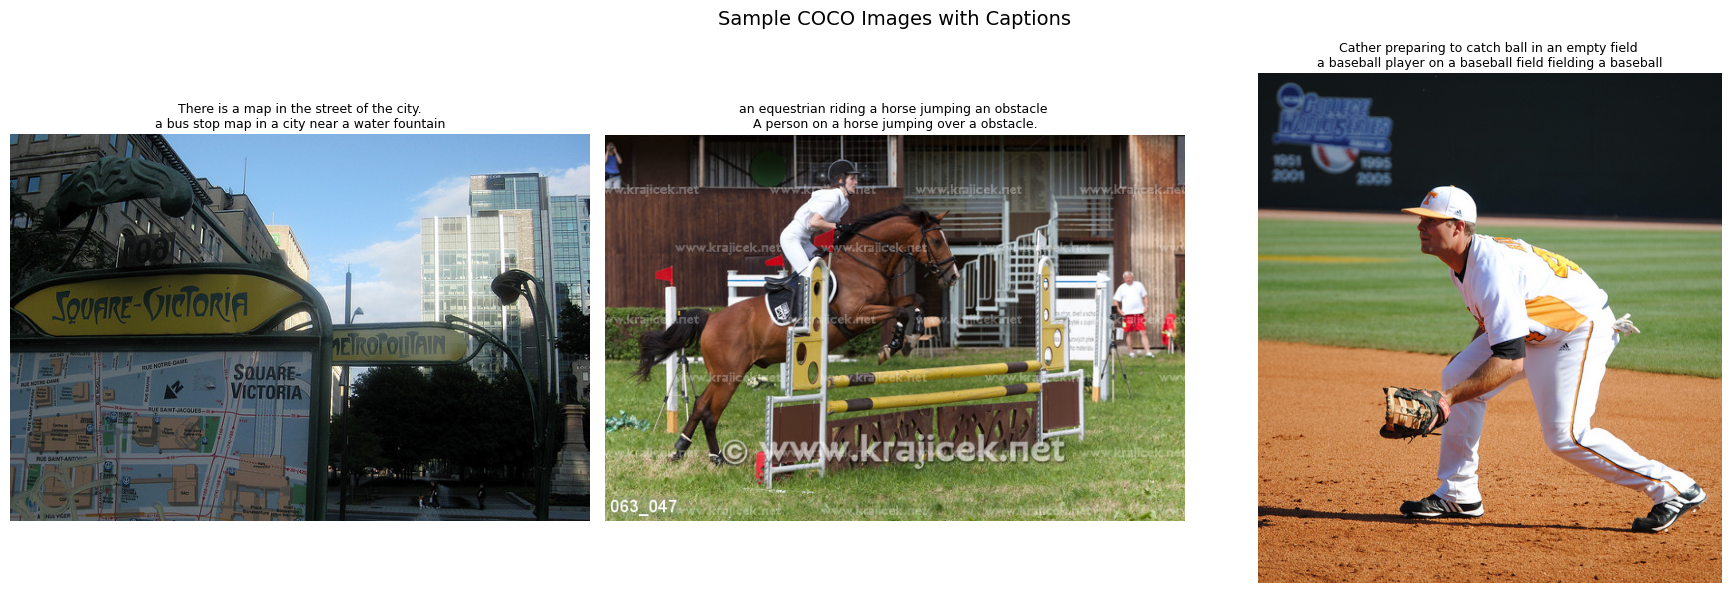

In [7]:
# Visualize sample images with their captions
img_dir = os.path.join(DATA_DIR, 'val2017')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, img_id in zip(axes, sample_ids):
    img_path = os.path.join(img_dir, img_id_to_filename[img_id])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title('\n'.join(img_id_to_captions[img_id][:2]), fontsize=9, wrap=True)
    ax.axis('off')

plt.suptitle('Sample COCO Images with Captions', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Build Vocabulary

Tokenize all captions and build a word-to-index vocabulary, including special tokens.

In [8]:
class Vocabulary:
    """
    A vocabulary that maps words to indices and vice versa.
    
    Special tokens:
        <pad>   : padding token (index 0)
        <start> : start-of-sequence token (index 1)
        <end>   : end-of-sequence token (index 2)
        <unk>   : unknown word token (index 3)
    """
    
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}
        self.word_count = Counter()
        self.idx = 4  # Start after special tokens
    
    def build_vocabulary(self, captions_list):
        """Build vocabulary from a list of caption strings."""
        # Count word frequencies
        for caption in captions_list:
            tokens = word_tokenize(caption.lower())
            self.word_count.update(tokens)
        
        # Add words that meet the frequency threshold
        for word, count in self.word_count.items():
            if count >= self.freq_threshold:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1
        
        print(f"Vocabulary built: {len(self.word2idx)} words "
              f"(threshold={self.freq_threshold})")
    
    def numericalize(self, caption):
        """
        Convert a caption string to a list of token indices.
        Wraps with <start> and <end> tokens.
        """
        tokens = word_tokenize(caption.lower())
        indices = [self.word2idx['<start>']]
        indices += [self.word2idx.get(tok, self.word2idx['<unk>']) for tok in tokens]
        indices.append(self.word2idx['<end>'])
        return indices
    
    def decode(self, indices):
        """Convert a list of indices back to a string."""
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, '<unk>')
            if word == '<end>':
                break
            if word not in ('<start>', '<pad>'):
                words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary from all captions
all_captions = [ann['caption'] for ann in captions_data['annotations']]

vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(all_captions)

# Test
sample_caption = all_captions[0]
print(f"\nOriginal: {sample_caption}")
indices = vocab.numericalize(sample_caption)
print(f"Numericalized: {indices}")
print(f"Decoded: {vocab.decode(indices)}")

Vocabulary built: 2335 words (threshold=5)

Original: A black Honda motorcycle parked in front of a garage.
Numericalized: [1, 4, 5, 3, 6, 7, 8, 9, 10, 4, 11, 12, 2]
Decoded: a black <unk> motorcycle parked in front of a garage .


## 5. Create Custom Dataset and DataLoader

In [9]:
class CocoImageCaptionDataset(torch.utils.data.Dataset):
    """
    Dataset for MS-COCO image captioning.
    
    Each sample returns:
        - image: Transformed image tensor [3, 224, 224]
        - caption: Numericalized caption as a tensor
    """
    
    def __init__(self, img_dir, annotations_file, vocab, transform=None, max_len=50):
        self.img_dir = img_dir
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len
        
        with open(annotations_file, 'r') as f:
            data = json.load(f)
        
        self.img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
        
        # Each annotation is one (image, caption) pair
        self.annotations = data['annotations']
    
    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann['image_id']
        caption = ann['caption']
        
        # Load image
        img_path = os.path.join(self.img_dir, self.img_id_to_filename[img_id])
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # Numericalize caption
        caption_indices = self.vocab.numericalize(caption)
        
        # Truncate or pad to max_len
        if len(caption_indices) > self.max_len:
            caption_indices = caption_indices[:self.max_len]
        
        caption_tensor = torch.tensor(caption_indices, dtype=torch.long)
        
        return img, caption_tensor
    
    def __len__(self):
        return len(self.annotations)


def caption_collate_fn(batch):
    """
    Custom collate function to pad captions to the same length within a batch.
    """
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    
    # Pad captions to the length of the longest caption in the batch
    lengths = [len(cap) for cap in captions]
    max_len = max(lengths)
    padded_captions = torch.zeros(len(captions), max_len, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded_captions[i, :len(cap)] = cap
    
    lengths = torch.tensor(lengths, dtype=torch.long)
    return images, padded_captions, lengths


# Define image transforms
transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Create dataset
dataset = CocoImageCaptionDataset(
    img_dir=os.path.join(DATA_DIR, 'val2017'),
    annotations_file=os.path.join(DATA_DIR, 'annotations', 'captions_val2017.json'),
    vocab=vocab,
    transform=transform
)

print(f"Dataset size: {len(dataset)}")

# Split into train/val (using val2017 images for development)
torch.manual_seed(42)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=caption_collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=caption_collate_fn
)

# Test a batch
images, captions, lengths = next(iter(train_loader))
print(f"\nBatch check:")
print(f"  Images shape: {images.shape}")
print(f"  Captions shape: {captions.shape}")
print(f"  Lengths: {lengths[:5]}")
print(f"  Sample decoded: {vocab.decode(captions[0].tolist())}")

Dataset size: 25014
Train size: 22512, Val size: 2502

Batch check:
  Images shape: torch.Size([32, 3, 224, 224])
  Captions shape: torch.Size([32, 22])
  Lengths: tensor([14, 14, 11, 13, 14])
  Sample decoded: a man riding a skateboard on top of a wooden bench .


## 6. Encoder-Decoder Architecture

The **encoder** is a pre-trained CNN (ResNet-50) that extracts image features. We have provided the encoder for you (resnet50).The **decoder** is an RNN (LSTM) that generates captions word by word. Your task is to implement and experiment with different decoders.

In [1]:
class EncoderCNN(nn.Module):
    """
    CNN Encoder using a pre-trained ResNet-50.
    Extracts a fixed-size feature vector from an input image.
    
    The final fully connected layer of ResNet is replaced with
    a linear projection to the desired embedding dimension.
    """
    
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        
        # Remove the final FC layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
        # Project to embedding space
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
    
    def forward(self, images):
        # Freeze CNN weights (or fine-tune later)
        with torch.no_grad():
            features = self.resnet(images)
        
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    """
    RNN Decoder using LSTM.
    Takes image features and generates captions word by word.
    
    TODO: This is a basic implementation. You should experiment with:
    - Attention mechanisms
    - Transformer-based decoders
    - Beam search for inference
    """
    
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        pass
    
    def forward(self, features, captions):
        """
        Forward pass for training.
        
        Args:
            features: Image features from encoder [batch, embed_size]
            captions: Target captions [batch, max_len]
        
        Returns:
            outputs: Predicted word scores [batch, max_len, vocab_size]
        """
        pass
    
    def generate(self, features, max_len=20, vocab=None):
        """
        Generate a caption for a single image (greedy decoding).
        
        Args:
            features: Image features [1, embed_size]
            max_len: Maximum caption length
            vocab: Vocabulary object for decoding
        
        Returns:
            generated_ids: List of generated token indices
        """
        pass

NameError: name 'nn' is not defined